In [25]:
import pyabc
import numpy as np
import scipy as sp
import os
import tempfile
import matplotlib.pyplot as plt

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

def model(p):
    ss = {}
    for j in range(N0):
        ss['p0_' + str(j)] = p['p0'] + sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = p['p1'] + 0.1 * sp.randn()
    return ss

def model(p):
    ss = {}
    s0 = p['p0'] + sp.randn()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.1 * sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

In [26]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=32, start_time=2019-09-16 13:17:10.385190, end_time=None)>
INFO:Epsilon:initial epsilon is 555.943404928064
INFO:ABC:t:0 eps:555.943404928064
INFO:ABC:t:1 eps:255.53575572546535
INFO:ABC:t:2 eps:126.83049312368819
INFO:ABC:t:3 eps:66.78789948659889
INFO:ABC:t:4 eps:33.10783776130441
INFO:ABC:t:5 eps:16.495379177639
INFO:ABC:t:6 eps:10.569943398926272
INFO:ABC:t:7 eps:6.871160584598761
INFO:ABC:t:8 eps:5.247060813506895
INFO:ABC:t:9 eps:3.832822688621831
INFO:History:Done <ABCSMC(id=32, start_time=2019-09-16 13:17:10.385190, end_time=2019-09-16 13:18:24.443038)>


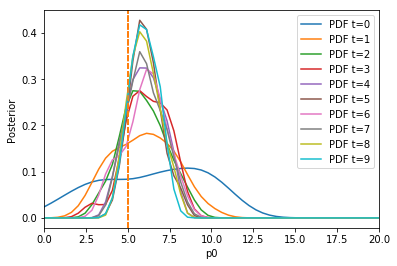

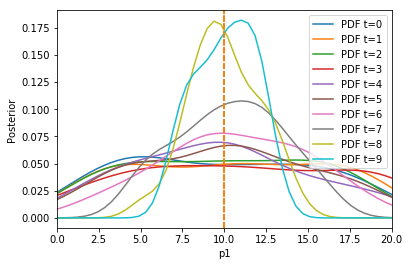

In [27]:
# plotting

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                    x='p0', ax=ax,
                                    label="PDF t={}".format(t),
                                    refval=p_true)
ax.legend()

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                    x='p1', ax=ax,
                                    label="PDF t={}".format(t),
                                    refval=p_true)
ax.legend()

INFO:History:Start <ABCSMC(id=33, start_time=2019-09-16 13:18:25.592245, end_time=None)>
DEBUG:Distance:update distance weights = {'p0_0': 0.5041905910530721, 'p0_1': 0.5041905910530721, 'p0_2': 0.5041905910530721, 'p0_3': 0.5041905910530721, 'p0_4': 0.5041905910530721, 'p0_5': 0.5041905910530721, 'p0_6': 0.5041905910530721, 'p0_7': 0.5041905910530721, 'p0_8': 0.5041905910530721, 'p0_9': 0.5041905910530721, 'p0_10': 0.5041905910530721, 'p0_11': 0.5041905910530721, 'p0_12': 0.5041905910530721, 'p0_13': 0.5041905910530721, 'p0_14': 0.5041905910530721, 'p0_15': 0.5041905910530721, 'p0_16': 0.5041905910530721, 'p0_17': 0.5041905910530721, 'p0_18': 0.5041905910530721, 'p0_19': 0.5041905910530721, 'p0_20': 0.5041905910530721, 'p0_21': 0.5041905910530721, 'p0_22': 0.5041905910530721, 'p0_23': 0.5041905910530721, 'p0_24': 0.5041905910530721, 'p0_25': 0.5041905910530721, 'p0_26': 0.5041905910530721, 'p0_27': 0.5041905910530721, 'p0_28': 0.5041905910530721, 'p0_29': 0.5041905910530721, 'p0_30': 

INFO:ABC:t:2 eps:272.1440327097158
DEBUG:Distance:update distance weights = {'p0_0': 0.5635536749288775, 'p0_1': 0.5635536749288775, 'p0_2': 0.5635536749288775, 'p0_3': 0.5635536749288775, 'p0_4': 0.5635536749288775, 'p0_5': 0.5635536749288775, 'p0_6': 0.5635536749288775, 'p0_7': 0.5635536749288775, 'p0_8': 0.5635536749288775, 'p0_9': 0.5635536749288775, 'p0_10': 0.5635536749288775, 'p0_11': 0.5635536749288775, 'p0_12': 0.5635536749288775, 'p0_13': 0.5635536749288775, 'p0_14': 0.5635536749288775, 'p0_15': 0.5635536749288775, 'p0_16': 0.5635536749288775, 'p0_17': 0.5635536749288775, 'p0_18': 0.5635536749288775, 'p0_19': 0.5635536749288775, 'p0_20': 0.5635536749288775, 'p0_21': 0.5635536749288775, 'p0_22': 0.5635536749288775, 'p0_23': 0.5635536749288775, 'p0_24': 0.5635536749288775, 'p0_25': 0.5635536749288775, 'p0_26': 0.5635536749288775, 'p0_27': 0.5635536749288775, 'p0_28': 0.5635536749288775, 'p0_29': 0.5635536749288775, 'p0_30': 0.5635536749288775, 'p0_31': 0.5635536749288775, 'p0_3

INFO:ABC:t:5 eps:91.50251968606092
DEBUG:Distance:update distance weights = {'p0_0': 0.36206257183913126, 'p0_1': 0.36206257183913126, 'p0_2': 0.36206257183913126, 'p0_3': 0.36206257183913126, 'p0_4': 0.36206257183913126, 'p0_5': 0.36206257183913126, 'p0_6': 0.36206257183913126, 'p0_7': 0.36206257183913126, 'p0_8': 0.36206257183913126, 'p0_9': 0.36206257183913126, 'p0_10': 0.36206257183913126, 'p0_11': 0.36206257183913126, 'p0_12': 0.36206257183913126, 'p0_13': 0.36206257183913126, 'p0_14': 0.36206257183913126, 'p0_15': 0.36206257183913126, 'p0_16': 0.36206257183913126, 'p0_17': 0.36206257183913126, 'p0_18': 0.36206257183913126, 'p0_19': 0.36206257183913126, 'p0_20': 0.36206257183913126, 'p0_21': 0.36206257183913126, 'p0_22': 0.36206257183913126, 'p0_23': 0.36206257183913126, 'p0_24': 0.36206257183913126, 'p0_25': 0.36206257183913126, 'p0_26': 0.36206257183913126, 'p0_27': 0.36206257183913126, 'p0_28': 0.36206257183913126, 'p0_29': 0.36206257183913126, 'p0_30': 0.36206257183913126, 'p0

INFO:ABC:t:8 eps:24.437625076249752
DEBUG:Distance:update distance weights = {'p0_0': 0.16282972720600256, 'p0_1': 0.16282972720600256, 'p0_2': 0.16282972720600256, 'p0_3': 0.16282972720600256, 'p0_4': 0.16282972720600256, 'p0_5': 0.16282972720600256, 'p0_6': 0.16282972720600256, 'p0_7': 0.16282972720600256, 'p0_8': 0.16282972720600256, 'p0_9': 0.16282972720600256, 'p0_10': 0.16282972720600256, 'p0_11': 0.16282972720600256, 'p0_12': 0.16282972720600256, 'p0_13': 0.16282972720600256, 'p0_14': 0.16282972720600256, 'p0_15': 0.16282972720600256, 'p0_16': 0.16282972720600256, 'p0_17': 0.16282972720600256, 'p0_18': 0.16282972720600256, 'p0_19': 0.16282972720600256, 'p0_20': 0.16282972720600256, 'p0_21': 0.16282972720600256, 'p0_22': 0.16282972720600256, 'p0_23': 0.16282972720600256, 'p0_24': 0.16282972720600256, 'p0_25': 0.16282972720600256, 'p0_26': 0.16282972720600256, 'p0_27': 0.16282972720600256, 'p0_28': 0.16282972720600256, 'p0_29': 0.16282972720600256, 'p0_30': 0.16282972720600256, 'p

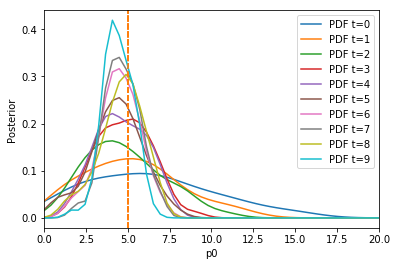

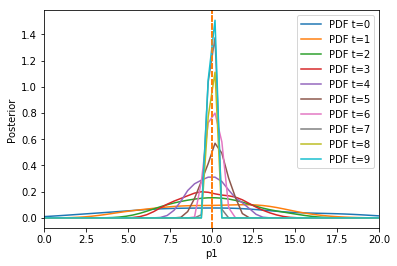

In [28]:
import logging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history = abc.run(max_nr_populations=10)

# plotting

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                    x='p0', ax=ax,
                                    label="PDF t={}".format(t),
                                    refval=p_true)
ax.legend()

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                    x='p1', ax=ax,
                                    label="PDF t={}".format(t),
                                    refval=p_true)
ax.legend()

INFO:History:Start <ABCSMC(id=34, start_time=2019-09-16 13:19:07.592747, end_time=None)>
DEBUG:Distance:update distance weights = {'p0_0': 1.000899147167967, 'p0_1': 1.000899147167967, 'p0_2': 1.000899147167967, 'p0_3': 1.000899147167967, 'p0_4': 1.000899147167967, 'p0_5': 1.000899147167967, 'p0_6': 1.000899147167967, 'p0_7': 1.000899147167967, 'p0_8': 1.000899147167967, 'p0_9': 1.000899147167967, 'p0_10': 1.000899147167967, 'p0_11': 1.000899147167967, 'p0_12': 1.000899147167967, 'p0_13': 1.000899147167967, 'p0_14': 1.000899147167967, 'p0_15': 1.000899147167967, 'p0_16': 1.000899147167967, 'p0_17': 1.000899147167967, 'p0_18': 1.000899147167967, 'p0_19': 1.000899147167967, 'p0_20': 1.000899147167967, 'p0_21': 1.000899147167967, 'p0_22': 1.000899147167967, 'p0_23': 1.000899147167967, 'p0_24': 1.000899147167967, 'p0_25': 1.000899147167967, 'p0_26': 1.000899147167967, 'p0_27': 1.000899147167967, 'p0_28': 1.000899147167967, 'p0_29': 1.000899147167967, 'p0_30': 1.000899147167967, 'p0_31': 1.

INFO:ABC:t:2 eps:97.06974529062812
DEBUG:Distance:update distance weights = {'p0_0': 1.0062986787950563, 'p0_1': 1.0062986787950563, 'p0_2': 1.0062986787950563, 'p0_3': 1.0062986787950563, 'p0_4': 1.0062986787950563, 'p0_5': 1.0062986787950563, 'p0_6': 1.0062986787950563, 'p0_7': 1.0062986787950563, 'p0_8': 1.0062986787950563, 'p0_9': 1.0062986787950563, 'p0_10': 1.0062986787950563, 'p0_11': 1.0062986787950563, 'p0_12': 1.0062986787950563, 'p0_13': 1.0062986787950563, 'p0_14': 1.0062986787950563, 'p0_15': 1.0062986787950563, 'p0_16': 1.0062986787950563, 'p0_17': 1.0062986787950563, 'p0_18': 1.0062986787950563, 'p0_19': 1.0062986787950563, 'p0_20': 1.0062986787950563, 'p0_21': 1.0062986787950563, 'p0_22': 1.0062986787950563, 'p0_23': 1.0062986787950563, 'p0_24': 1.0062986787950563, 'p0_25': 1.0062986787950563, 'p0_26': 1.0062986787950563, 'p0_27': 1.0062986787950563, 'p0_28': 1.0062986787950563, 'p0_29': 1.0062986787950563, 'p0_30': 1.0062986787950563, 'p0_31': 1.0062986787950563, 'p0_3

INFO:ABC:t:5 eps:11.006425852463536
DEBUG:Distance:update distance weights = {'p0_0': 1.0073243154818492, 'p0_1': 1.0073243154818492, 'p0_2': 1.0073243154818492, 'p0_3': 1.0073243154818492, 'p0_4': 1.0073243154818492, 'p0_5': 1.0073243154818492, 'p0_6': 1.0073243154818492, 'p0_7': 1.0073243154818492, 'p0_8': 1.0073243154818492, 'p0_9': 1.0073243154818492, 'p0_10': 1.0073243154818492, 'p0_11': 1.0073243154818492, 'p0_12': 1.0073243154818492, 'p0_13': 1.0073243154818492, 'p0_14': 1.0073243154818492, 'p0_15': 1.0073243154818492, 'p0_16': 1.0073243154818492, 'p0_17': 1.0073243154818492, 'p0_18': 1.0073243154818492, 'p0_19': 1.0073243154818492, 'p0_20': 1.0073243154818492, 'p0_21': 1.0073243154818492, 'p0_22': 1.0073243154818492, 'p0_23': 1.0073243154818492, 'p0_24': 1.0073243154818492, 'p0_25': 1.0073243154818492, 'p0_26': 1.0073243154818492, 'p0_27': 1.0073243154818492, 'p0_28': 1.0073243154818492, 'p0_29': 1.0073243154818492, 'p0_30': 1.0073243154818492, 'p0_31': 1.0073243154818492, 'p0_

INFO:ABC:t:8 eps:2.6921838697146003
DEBUG:Distance:update distance weights = {'p0_0': 1.006971203862029, 'p0_1': 1.006971203862029, 'p0_2': 1.006971203862029, 'p0_3': 1.006971203862029, 'p0_4': 1.006971203862029, 'p0_5': 1.006971203862029, 'p0_6': 1.006971203862029, 'p0_7': 1.006971203862029, 'p0_8': 1.006971203862029, 'p0_9': 1.006971203862029, 'p0_10': 1.006971203862029, 'p0_11': 1.006971203862029, 'p0_12': 1.006971203862029, 'p0_13': 1.006971203862029, 'p0_14': 1.006971203862029, 'p0_15': 1.006971203862029, 'p0_16': 1.006971203862029, 'p0_17': 1.006971203862029, 'p0_18': 1.006971203862029, 'p0_19': 1.006971203862029, 'p0_20': 1.006971203862029, 'p0_21': 1.006971203862029, 'p0_22': 1.006971203862029, 'p0_23': 1.006971203862029, 'p0_24': 1.006971203862029, 'p0_25': 1.006971203862029, 'p0_26': 1.006971203862029, 'p0_27': 1.006971203862029, 'p0_28': 1.006971203862029, 'p0_29': 1.006971203862029, 'p0_30': 1.006971203862029, 'p0_31': 1.006971203862029, 'p0_32': 1.006971203862029, 'p0_33':

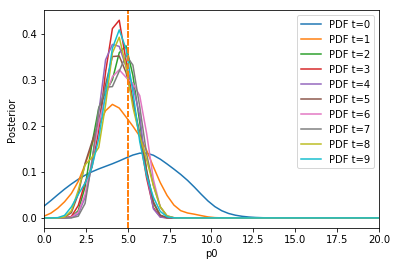

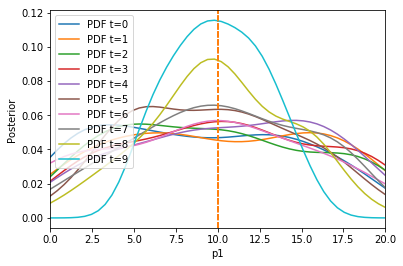

In [29]:
import logging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history = abc.run(max_nr_populations=10)

# plotting

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                    x='p0', ax=ax,
                                    label="PDF t={}".format(t),
                                    refval=p_true)
ax.legend()

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                    x='p1', ax=ax,
                                    label="PDF t={}".format(t),
                                    refval=p_true)
ax.legend()